In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
750    0.046654
751   -0.041721
752   -0.004281
753    0.038246
754    0.042989
755    0.042706
756   -0.045968
757    0.025651
758    0.045020
759    0.014518
760   -0.043308
761    0.044599
762   -0.025464
763   -0.054690
764    0.003660
765    0.079245
766    0.087195
767    0.007241
768   -0.089894
769   -0.133530
770   -0.040963
771    0.118600
772    0.187990
773    0.001373
774   -0.141620
775   -0.250010
776   -0.037291
777    0.165080
778    0.321170
779    0.303980
Name: f0, Length: 780, d

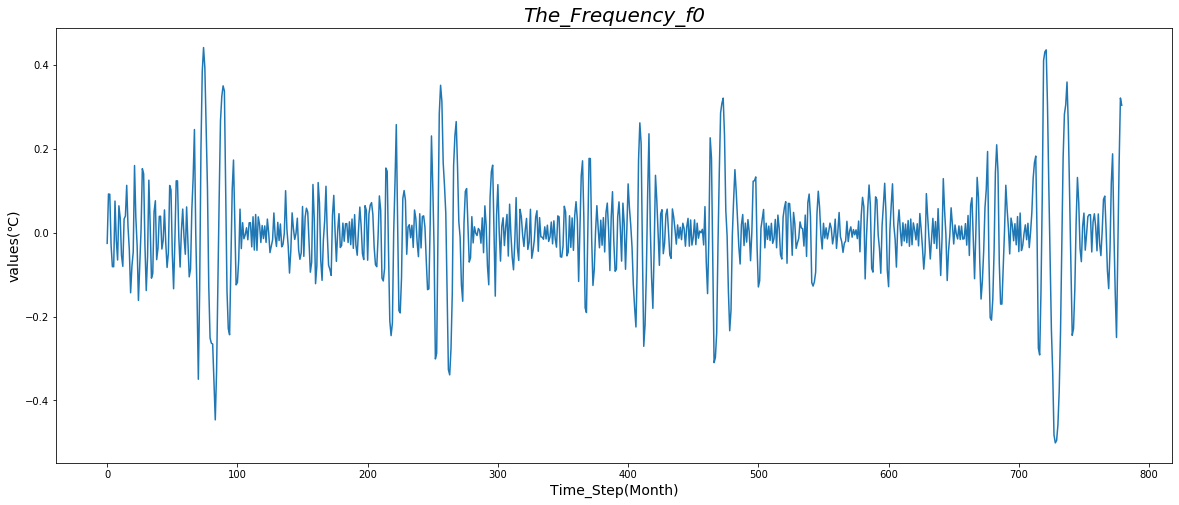

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 5s - loss: 0.0139
Epoch 2/200
 - 2s - loss: 0.0138
Epoch 3/200
 - 2s - loss: 0.0137
Epoch 4/200
 - 2s - loss: 0.0137
Epoch 5/200
 - 2s - loss: 0.0136
Epoch 6/200
 - 2s - loss: 0.0133
Epoch 7/200
 - 2s - loss: 0.0134
Epoch 8/200
 - 2s - loss: 0.0127
Epoch 9/200
 - 1s - loss: 0.0122
Epoch 10/200
 - 2s - loss: 0.0119
Epoch 11/200
 - 2s - loss: 0.0113
Epoch 12/200
 - 2s - loss: 0.0117
Epoch 13/200
 - 2s - loss: 0.0112
Epoch 14/200
 - 2s - loss: 0.0109
Epoch 15/200
 - 2s - loss: 0.0103
Epoch 16/200
 - 2s - loss: 0.0102
Epoch 17/200
 - 2s - loss: 0.0098
Epoch 18/200
 - 2s - loss: 0.0097
Epoch 19/200
 - 2s - loss: 0.0097
Epoch 20/200
 - 4s - loss: 0.0095
Epoch 21/200
 - 3s - loss: 0.0092
Epoch 22/200
 - 3s - loss: 0.0092
Epoch 23/200
 - 3s - loss: 0.0091
Epoch 24/200
 - 3s - loss: 0.0090
Epoch 25/200
 - 2s - loss: 0.0088
Epoch 26/200
 - 2s - loss: 0.0086
Epoch 27/200
 - 2s - loss: 0.0084
Epoch 28/200
 - 2s - loss: 0.0085
Epoch 29/

(62, 12)


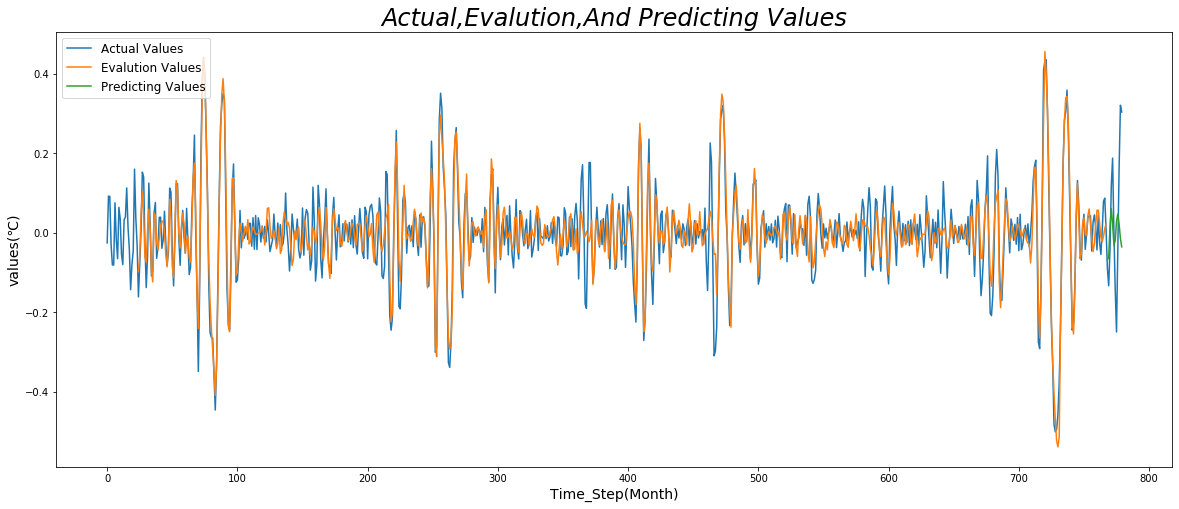

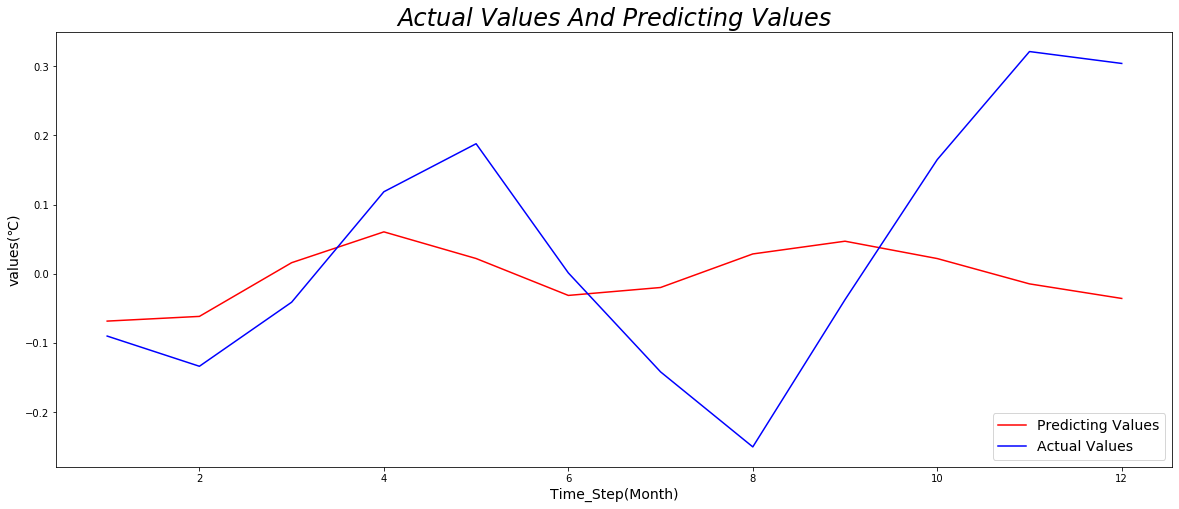

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
750    0.180610
751    0.260780
752    0.248830
753    0.157580
754    0.019498
755   -0.108560
756   -0.153610
757   -0.072965
758    0.044407
759    0.096376
760    0.061819
761   -0.026199
762   -0.056685
763   -0.023493
764    0.022220
765    0.044032
766    0.021371
767   -0.025670
768   -0.066672
769   -0.071024
770   -0.019692
771    0.057821
772    0.119830
773    0.133310
774    0.099123
775    0.024204
776   -0.080189
777   -0.182900
778   -0.248040
779   -0.249480
Name: f1, Length: 780, d

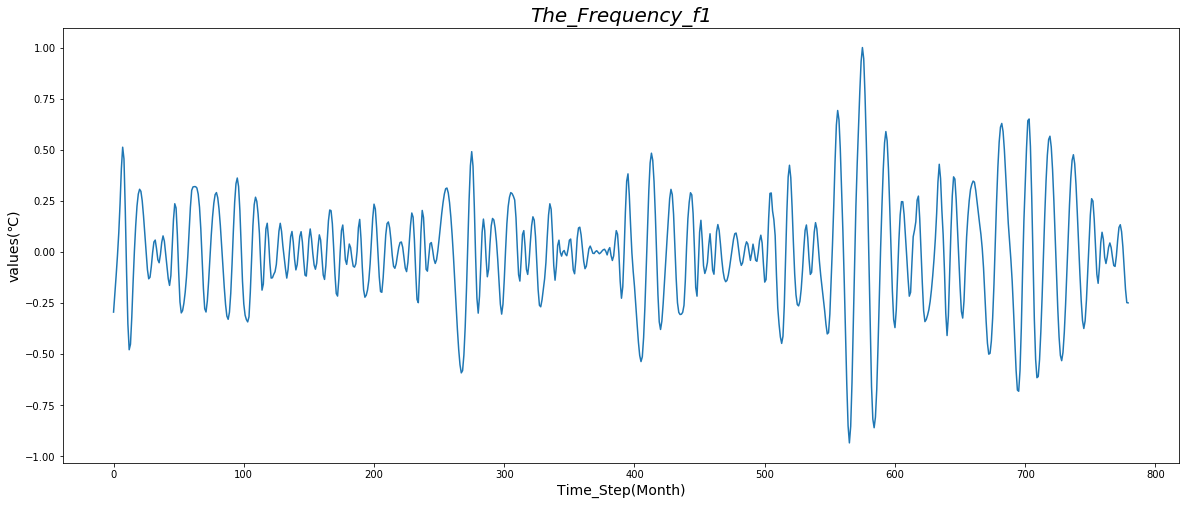

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 11s - loss: 0.0644
Epoch 2/200
 - 2s - loss: 0.0580
Epoch 3/200
 - 2s - loss: 0.0472
Epoch 4/200
 - 2s - loss: 0.0431
Epoch 5/200
 - 2s - loss: 0.0425
Epoch 6/200
 - 2s - loss: 0.0368
Epoch 7/200
 - 2s - loss: 0.0345
Epoch 8/200
 - 2s - loss: 0.0341
Epoch 9/200
 - 2s - loss: 0.0328
Epoch 10/200
 - 2s - loss: 0.0317
Epoch 11/200
 - 2s - loss: 0.0307
Epoch 12/200
 - 2s - loss: 0.0297
Epoch 13/200
 - 2s - loss: 0.0314
Epoch 14/200
 - 2s - loss: 0.0286
Epoch 15/200
 - 2s - loss: 0.0276
Epoch 16/200
 - 2s - loss: 0.0281
Epoch 17/200
 - 2s - loss: 0.0265
Epoch 18/200
 - 2s - loss: 0.0271
Epoch 19/200
 - 2s - loss: 0.0258
Epoch 20/200
 - 2s - loss: 0.0251
Epoch 21/200
 - 2s - loss: 0.0269
Epoch 22/200
 - 2s - loss: 0.0281
Epoch 23/200
 - 2s - loss: 0.0252
Epoch 24/200
 - 2s - loss: 0.0241
Epoch 25/200
 - 2s - loss: 0.0255
Epoch 26/200
 - 2s - loss: 0.0244
Epoch 27/200
 - 2s - loss: 0.0233
Epoch 28/200
 - 2s - loss: 0.0224
Epoch 29/200
 - 2s - loss: 0.0248
Epoch 30/200
 - 2s - l

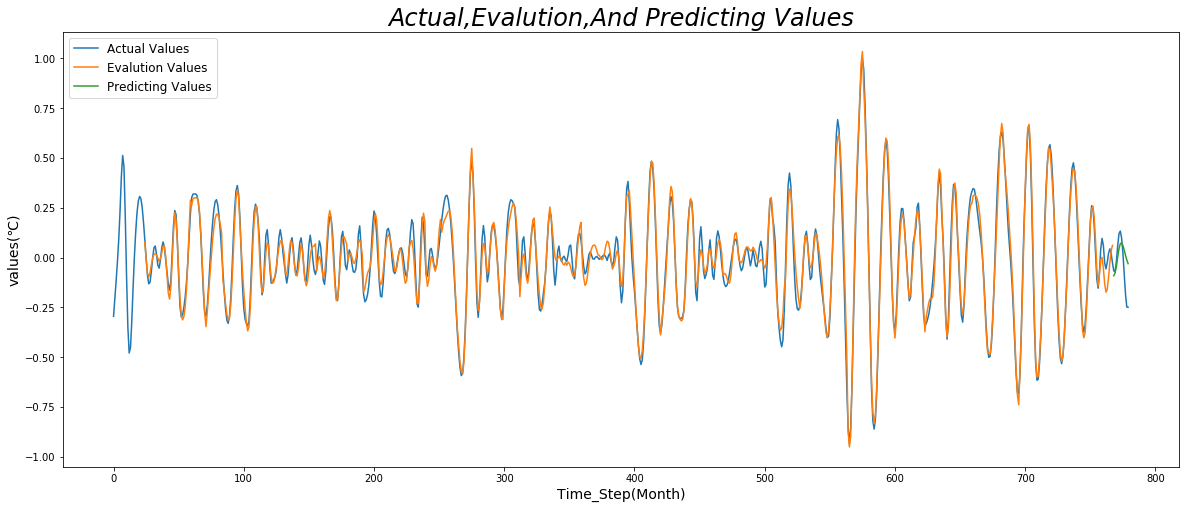

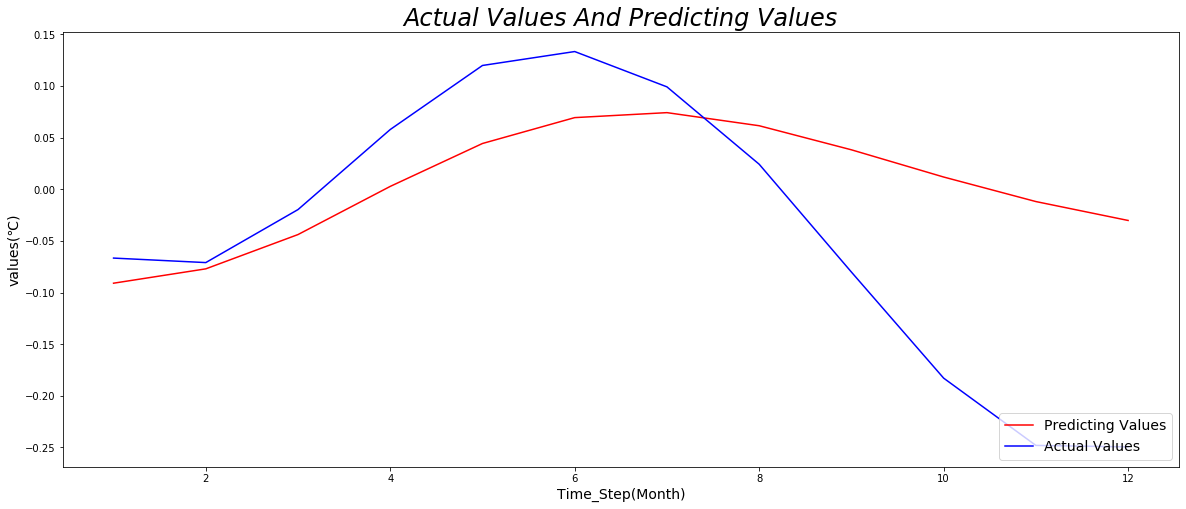

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
750    0.220720
751    0.214080
752    0.182920
753    0.134410
754    0.077831
755    0.022456
756   -0.022442
757   -0.049362
758   -0.057898
759   -0.049598
760   -0.028074
761   -0.002634
762    0.015288
763    0.017141
764    0.006707
765   -0.008962
766   -0.023666
767   -0.036315
768   -0.047196
769   -0.056760
770   -0.065907
771   -0.075071
772   -0.084464
773   -0.094279
774   -0.104070
775   -0.110790
776   -0.111170
777   -0.103810
778   -0.087494
779   -0.060201
Name: f2, Length: 780, d

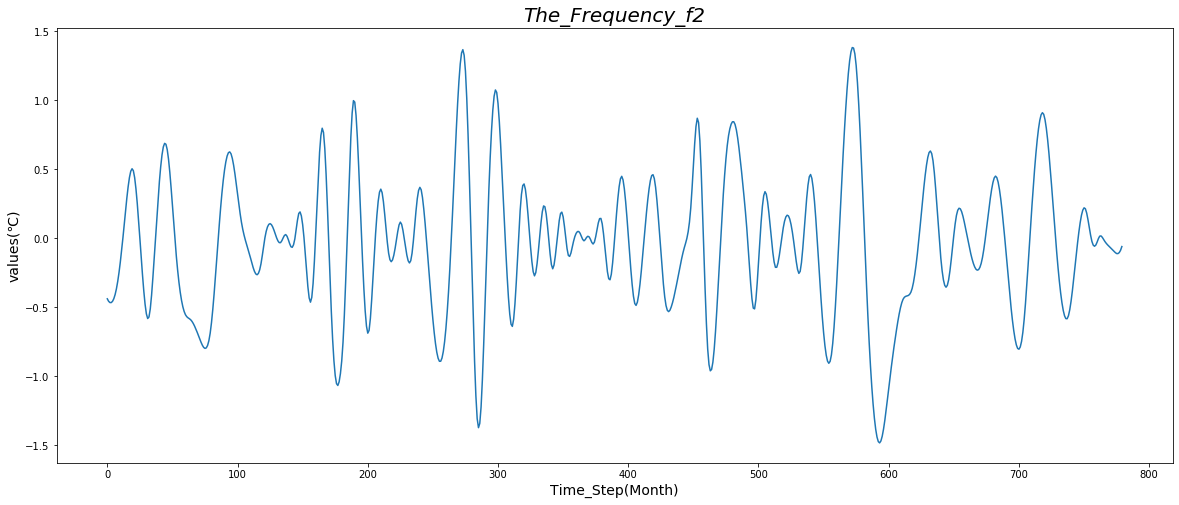

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 7s - loss: 0.2448
Epoch 2/200
 - 3s - loss: 0.2331
Epoch 3/200
 - 2s - loss: 0.2137
Epoch 4/200
 - 2s - loss: 0.1634
Epoch 5/200
 - 2s - loss: 0.1266
Epoch 6/200
 - 2s - loss: 0.1130
Epoch 7/200
 - 2s - loss: 0.0944
Epoch 8/200
 - 2s - loss: 0.0898
Epoch 9/200
 - 2s - loss: 0.0807
Epoch 10/200
 - 2s - loss: 0.0784
Epoch 11/200
 - 2s - loss: 0.0758
Epoch 12/200
 - 2s - loss: 0.0664
Epoch 13/200
 - 2s - loss: 0.0793
Epoch 14/200
 - 2s - loss: 0.0763
Epoch 15/200
 - 2s - loss: 0.0641
Epoch 16/200
 - 2s - loss: 0.0560
Epoch 17/200
 - 2s - loss: 0.0545
Epoch 18/200
 - 2s - loss: 0.0550
Epoch 19/200
 - 2s - loss: 0.0603
Epoch 20/200
 - 2s - loss: 0.0588
Epoch 21/200
 - 2s - loss: 0.0542
Epoch 22/200
 - 2s - loss: 0.0555
Epoch 23/200
 - 2s - loss: 0.0551
Epoch 24/200
 - 2s - loss: 0.0501
Epoch 25/200
 - 2s - loss: 0.0445
Epoch 26/200
 - 2s - loss: 0.0449
Epoch 27/200
 - 2s - loss: 0.0501
Epoch 28/200
 - 2s - loss: 0.0451
Epoch 29/200
 - 2s - loss: 0.0437
Epoch 30/200
 - 2s - lo

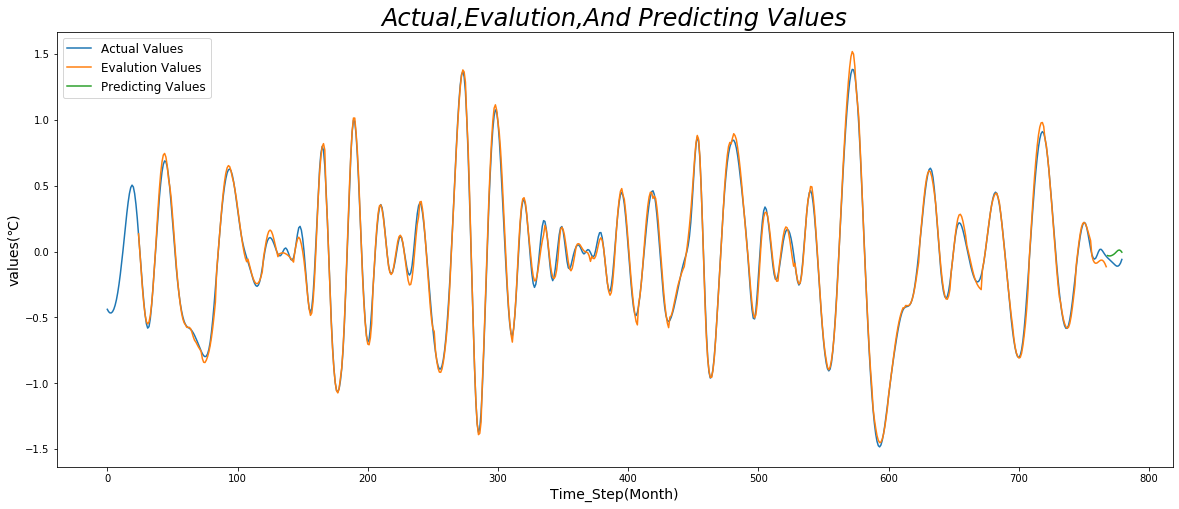

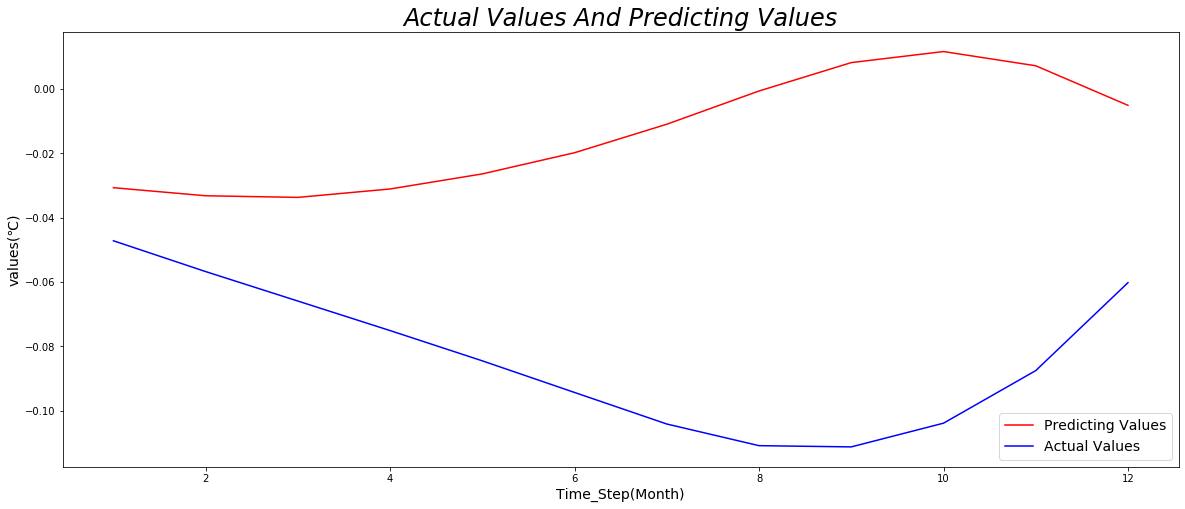

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
750    0.213890
751    0.207050
752    0.189680
753    0.162600
754    0.127040
755    0.084259
756    0.035490
757   -0.018022
758   -0.075032
759   -0.134110
760   -0.192950
761   -0.248230
762   -0.295680
763   -0.331570
764   -0.355150
765   -0.366600
766   -0.366600
767   -0.356020
768   -0.335670
769   -0.306350
770   -0.268860
771   -0.224020
772   -0.172700
773   -0.115830
774   -0.054297
775    0.010972
776    0.079005
777    0.148710
778    0.218990
779    0.288710
Name: f3, Length: 780, d

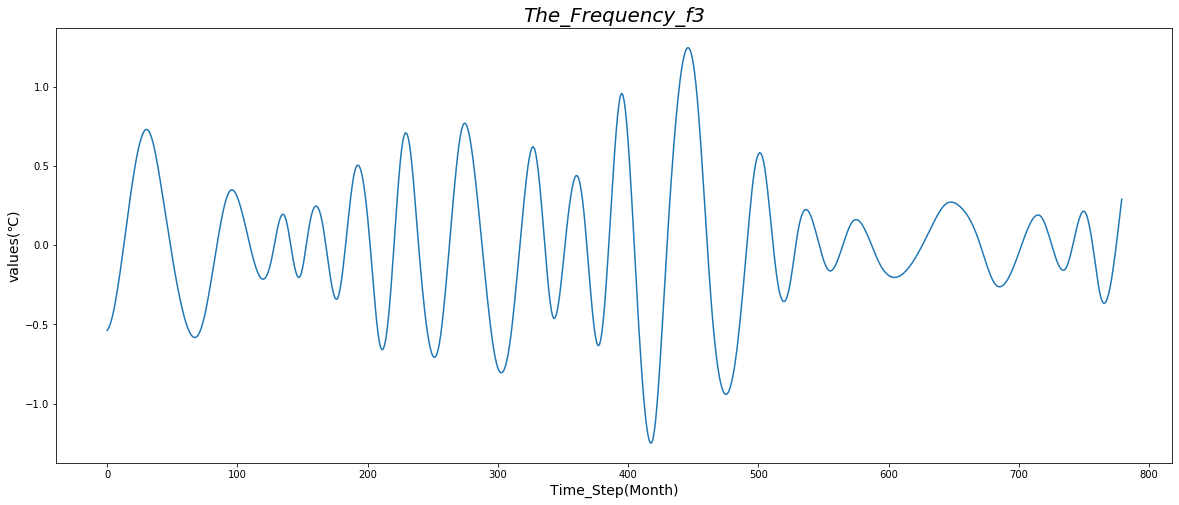

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 9s - loss: 0.1392
Epoch 2/200
 - 3s - loss: 0.1091
Epoch 3/200
 - 3s - loss: 0.0710
Epoch 4/200
 - 2s - loss: 0.0545
Epoch 5/200
 - 2s - loss: 0.0430
Epoch 6/200
 - 2s - loss: 0.0302
Epoch 7/200
 - 2s - loss: 0.0244
Epoch 8/200
 - 2s - loss: 0.0243
Epoch 9/200
 - 2s - loss: 0.0177
Epoch 10/200
 - 2s - loss: 0.0192
Epoch 11/200
 - 2s - loss: 0.0151
Epoch 12/200
 - 2s - loss: 0.0182
Epoch 13/200
 - 2s - loss: 0.0211
Epoch 14/200
 - 2s - loss: 0.0189
Epoch 15/200
 - 2s - loss: 0.0131
Epoch 16/200
 - 2s - loss: 0.0114
Epoch 17/200
 - 2s - loss: 0.0120
Epoch 18/200
 - 2s - loss: 0.0103
Epoch 19/200
 - 2s - loss: 0.0095
Epoch 20/200
 - 2s - loss: 0.0101
Epoch 21/200
 - 2s - loss: 0.0096
Epoch 22/200
 - 2s - loss: 0.0096
Epoch 23/200
 - 2s - loss: 0.0086
Epoch 24/200
 - 2s - loss: 0.0096
Epoch 25/200
 - 2s - loss: 0.0084
Epoch 26/200
 - 2s - loss: 0.0077
Epoch 27/200
 - 2s - loss: 0.0072
Epoch 28/200
 - 2s - loss: 0.0087
Epoch 29/200
 - 2s - loss: 0.0078
Epoch 30/200
 - 2s - lo

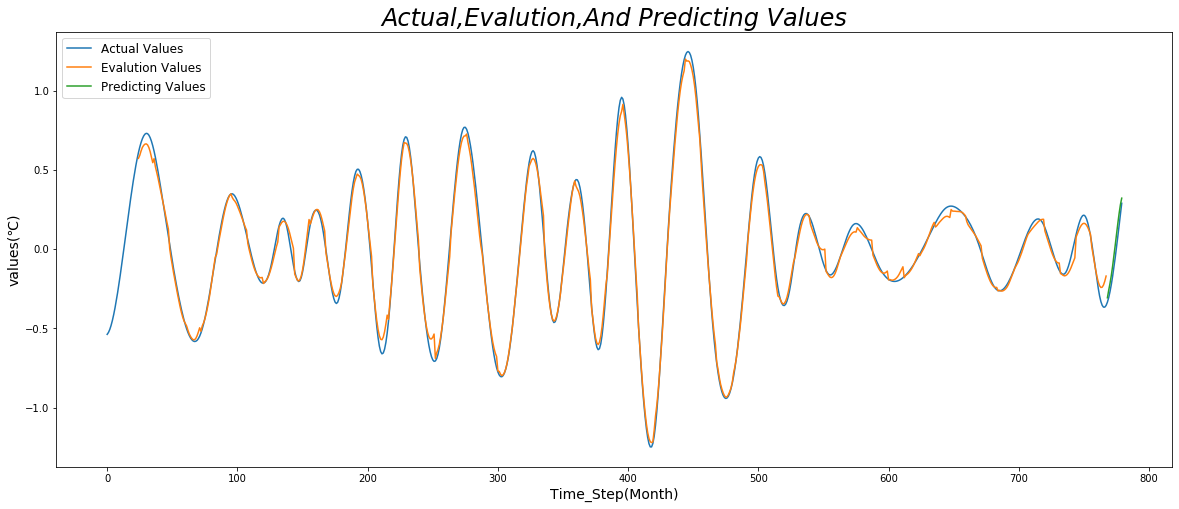

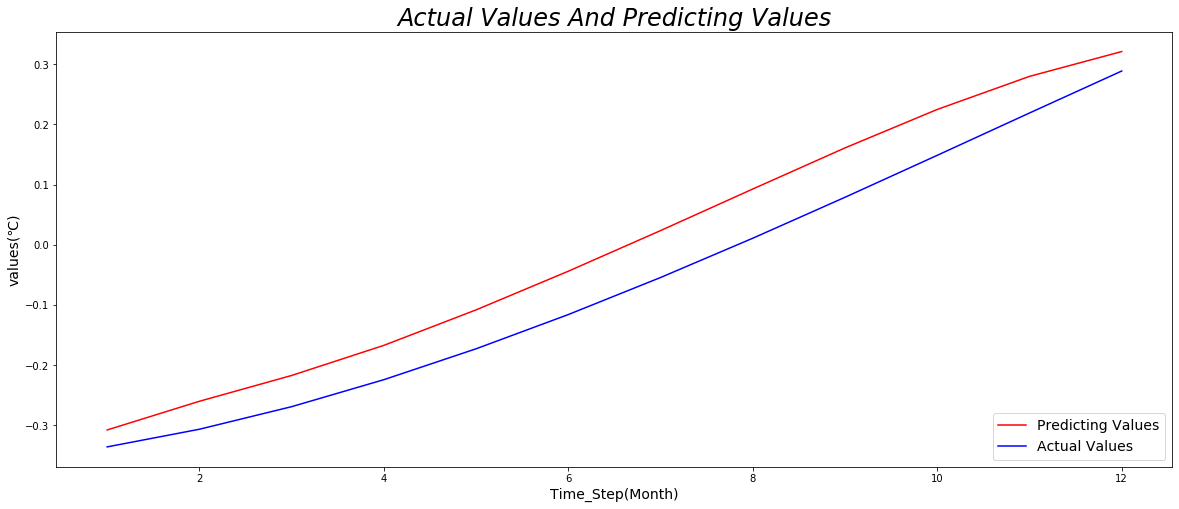

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
750   -0.333770
751   -0.317160
752   -0.299200
753   -0.279950
754   -0.259550
755   -0.238100
756   -0.215740
757   -0.192600
758   -0.168800
759   -0.144460
760   -0.119720
761   -0.094688
762   -0.069505
763   -0.044291
764   -0.019166
765    0.005776
766    0.030458
767    0.054833
768    0.078862
769    0.102510
770    0.125730
771    0.148500
772    0.170770
773    0.192500
774    0.213650
775    0.234200
776    0.254090
777    0.273300
778    0.291780
779    0.309490
Name: f4, Length: 780, d

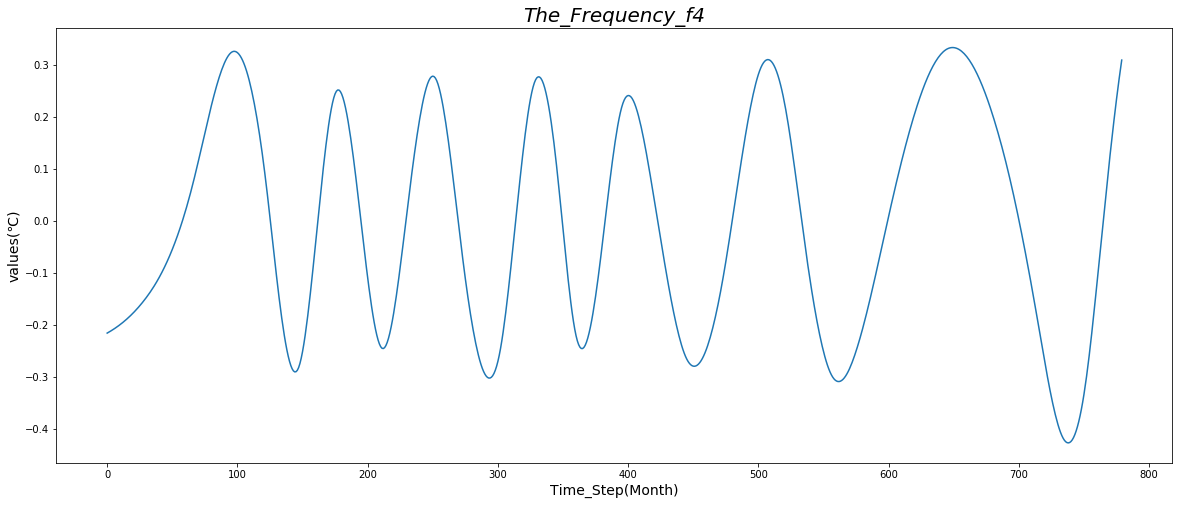

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 7s - loss: 0.0313
Epoch 2/200
 - 2s - loss: 0.0090
Epoch 3/200
 - 2s - loss: 0.0050
Epoch 4/200
 - 2s - loss: 0.0027
Epoch 5/200
 - 2s - loss: 0.0018
Epoch 6/200
 - 2s - loss: 0.0013
Epoch 7/200
 - 4s - loss: 0.0011
Epoch 8/200
 - 3s - loss: 8.9157e-04
Epoch 9/200
 - 3s - loss: 0.0012
Epoch 10/200
 - 3s - loss: 0.0014
Epoch 11/200
 - 2s - loss: 9.5555e-04
Epoch 12/200
 - 2s - loss: 7.0531e-04
Epoch 13/200
 - 2s - loss: 6.5337e-04
Epoch 14/200
 - 2s - loss: 6.7408e-04
Epoch 15/200
 - 2s - loss: 6.8841e-04
Epoch 16/200
 - 2s - loss: 9.9468e-04
Epoch 17/200
 - 2s - loss: 8.2551e-04
Epoch 18/200
 - 2s - loss: 8.7353e-04
Epoch 19/200
 - 2s - loss: 5.9265e-04
Epoch 20/200
 - 2s - loss: 5.0961e-04
Epoch 21/200
 - 2s - loss: 6.0523e-04
Epoch 22/200
 - 2s - loss: 4.4905e-04
Epoch 23/200
 - 2s - loss: 3.9550e-04
Epoch 24/200
 - 2s - loss: 4.2434e-04
Epoch 25/200
 - 2s - loss: 4.0738e-04
Epoch 26/200
 - 2s - loss: 4.7099e-04
Epoch 27/200
 - 2s - loss: 4.6126e-04
Epoch 28/200
 - 2s 

(62, 12)


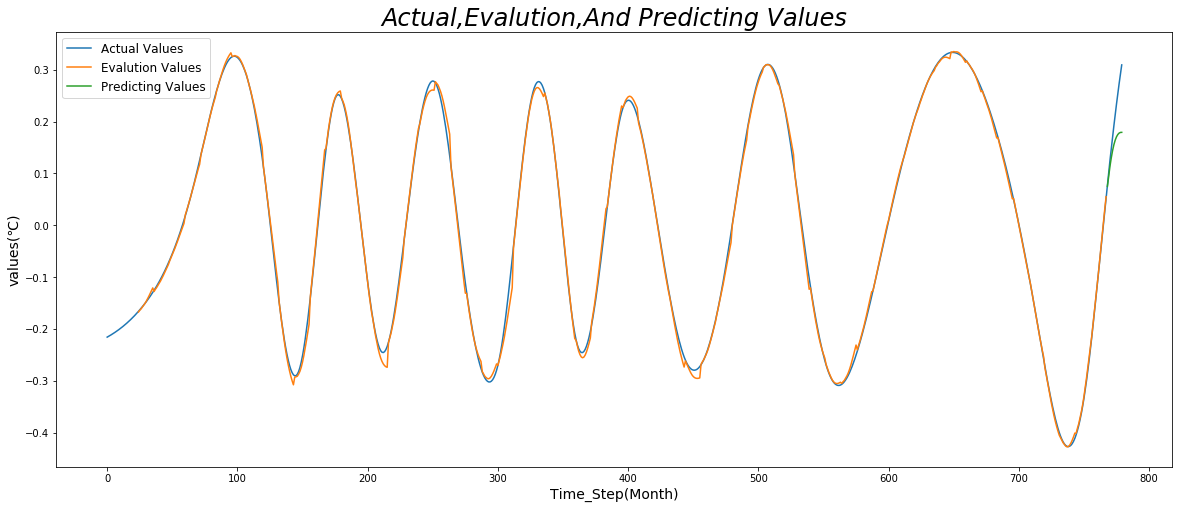

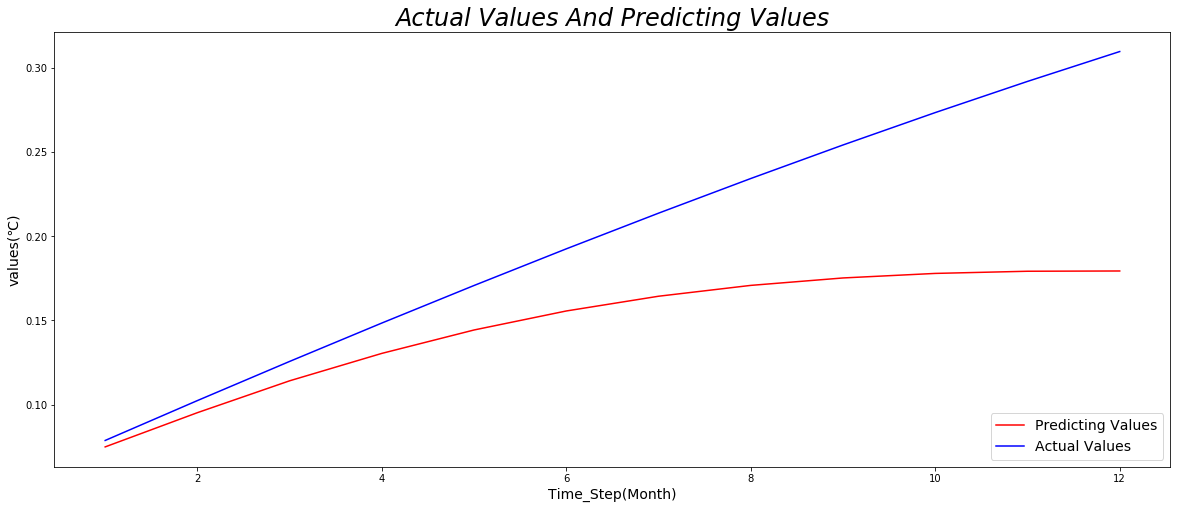

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
750    0.011488
751    0.015353
752    0.019215
753    0.023069
754    0.026914
755    0.030748
756    0.034566
757    0.038368
758    0.042150
759    0.045909
760    0.049644
761    0.053351
762    0.057028
763    0.060672
764    0.064282
765    0.067853
766    0.071384
767    0.074872
768    0.078314
769    0.081709
770    0.085052
771    0.088342
772    0.091576
773    0.094752
774    0.097867
775    0.100920
776    0.103900
777    0.106820
778    0.109660
779    0.112430
Name: f5, Length: 780, d

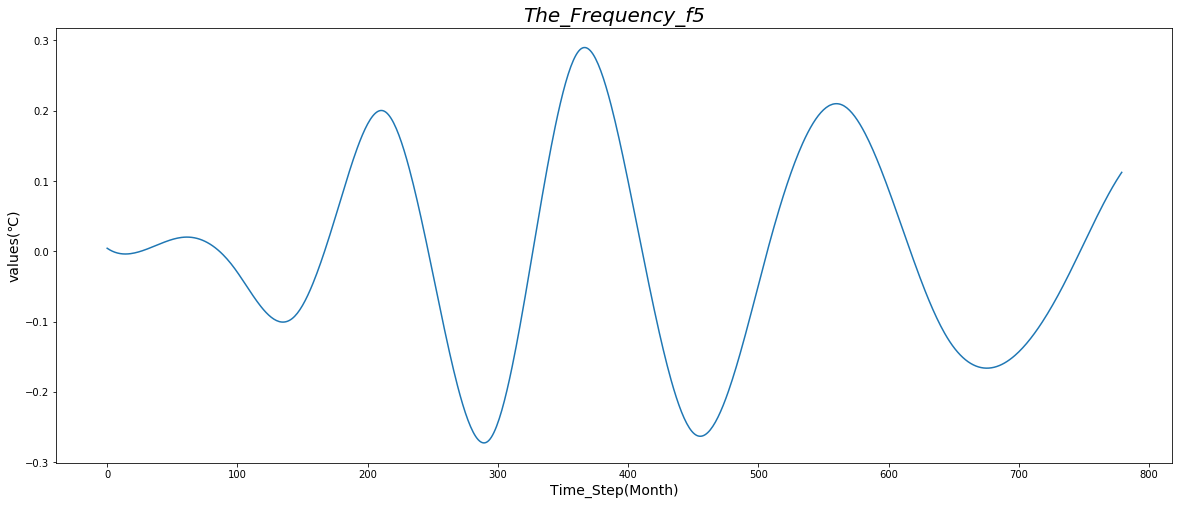

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 7s - loss: 0.0137
Epoch 2/200
 - 2s - loss: 0.0050
Epoch 3/200
 - 2s - loss: 0.0013
Epoch 4/200
 - 2s - loss: 5.9128e-04
Epoch 5/200
 - 2s - loss: 1.8612e-04
Epoch 6/200
 - 2s - loss: 1.1595e-04
Epoch 7/200
 - 2s - loss: 9.1841e-05
Epoch 8/200
 - 2s - loss: 8.2674e-05
Epoch 9/200
 - 2s - loss: 1.1121e-04
Epoch 10/200
 - 2s - loss: 6.8063e-05
Epoch 11/200
 - 2s - loss: 9.3618e-05
Epoch 12/200
 - 2s - loss: 8.4807e-05
Epoch 13/200
 - 2s - loss: 7.1095e-05
Epoch 14/200
 - 2s - loss: 5.7580e-05
Epoch 15/200
 - 2s - loss: 6.3484e-05
Epoch 16/200
 - 2s - loss: 7.2057e-05
Epoch 17/200
 - 2s - loss: 1.2654e-04
Epoch 18/200
 - 2s - loss: 5.9383e-05
Epoch 19/200
 - 2s - loss: 5.9313e-05
Epoch 20/200
 - 2s - loss: 5.1913e-05
Epoch 21/200
 - 2s - loss: 5.0272e-05
Epoch 22/200
 - 2s - loss: 3.9506e-05
Epoch 23/200
 - 2s - loss: 8.8383e-05
Epoch 24/200
 - 2s - loss: 1.3515e-04
Epoch 25/200
 - 2s - loss: 5.6620e-05
Epoch 26/200
 - 2s - loss: 5.2086e-05
Epoch 27/200
 - 2s - loss: 4.3107

(62, 12)


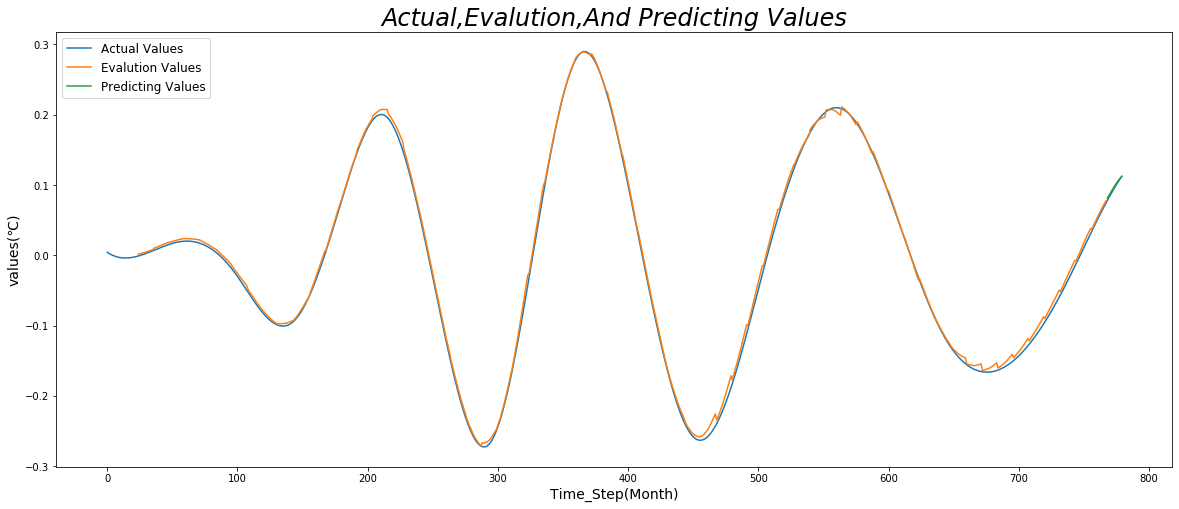

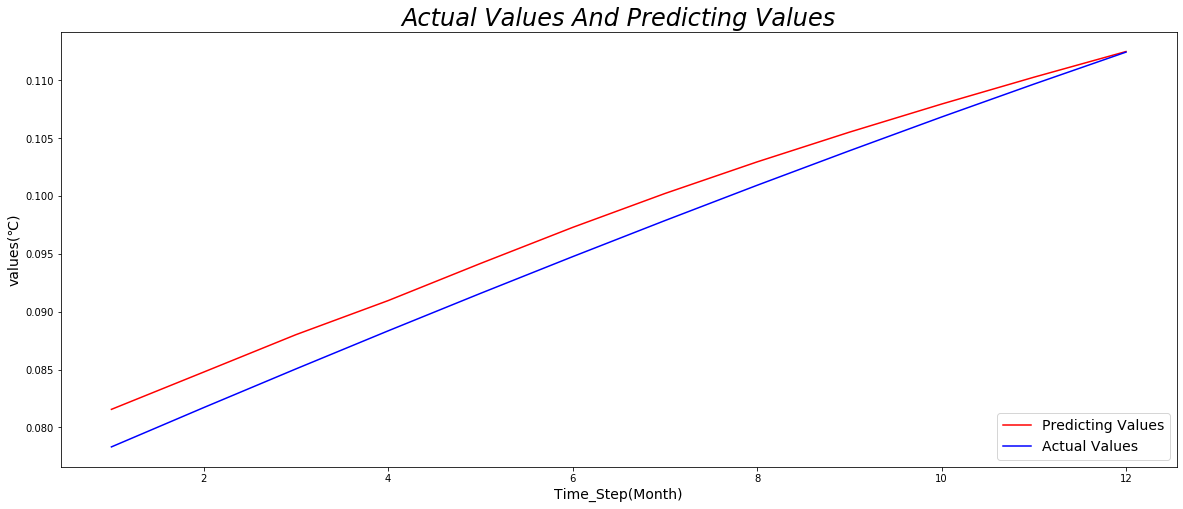

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
750   -0.15864
751   -0.15729
752   -0.15594
753   -0.15459
754   -0.15323
755   -0.15187
756   -0.15051
757   -0.14914
758   -0.14778
759   -0.14641
760   -0.14504
761   -0.14367
762   -0.14230
763   -0.14093
764   -0.13956
765   -0.13819
766   -0.13682
767   -0.13545
768   -0.13409
769   -0.13272
770   -0.13136
771   -0.13000
772   -0.12865
773   -0.12730
774   -0.12595
775   -0.12461
776   -0.12327
777   -0.12194
778   -0.12062
779   -0.11930
Name: f6, Length: 780, dtype: float64
(780,)


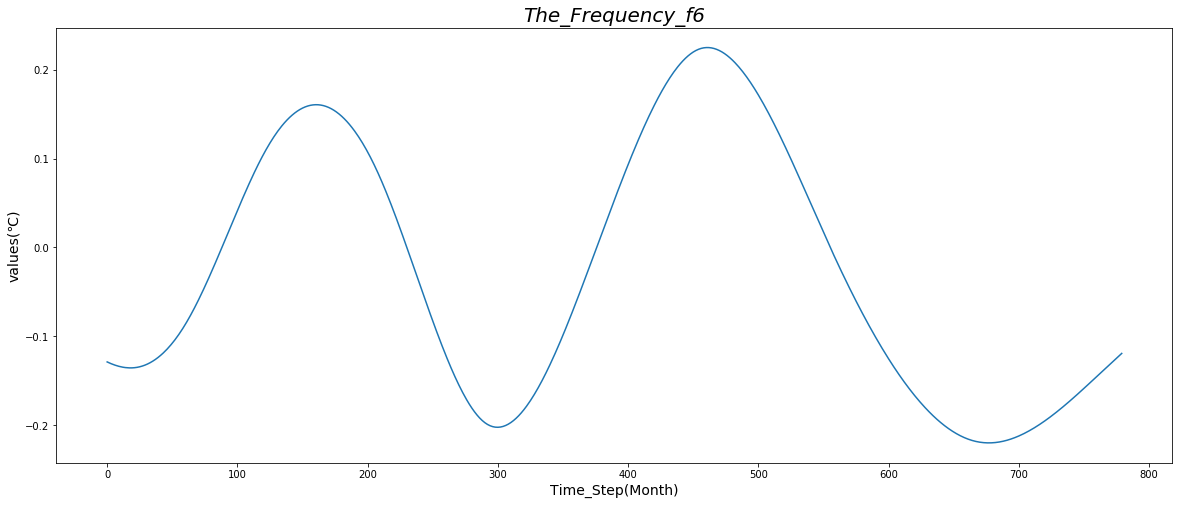

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 10s - loss: 0.0113
Epoch 2/200
 - 3s - loss: 0.0046
Epoch 3/200
 - 3s - loss: 0.0025
Epoch 4/200
 - 2s - loss: 0.0013
Epoch 5/200
 - 2s - loss: 5.1749e-04
Epoch 6/200
 - 2s - loss: 2.1309e-04
Epoch 7/200
 - 2s - loss: 9.7475e-05
Epoch 8/200
 - 2s - loss: 5.9658e-05
Epoch 9/200
 - 2s - loss: 4.8383e-05
Epoch 10/200
 - 2s - loss: 5.8314e-05
Epoch 11/200
 - 2s - loss: 3.2176e-05
Epoch 12/200
 - 2s - loss: 3.7561e-05
Epoch 13/200
 - 2s - loss: 2.0909e-05
Epoch 14/200
 - 2s - loss: 3.8319e-05
Epoch 15/200
 - 2s - loss: 2.9919e-05
Epoch 16/200
 - 2s - loss: 1.5089e-05
Epoch 17/200
 - 2s - loss: 1.4315e-05
Epoch 18/200
 - 2s - loss: 2.3399e-05
Epoch 19/200
 - 2s - loss: 1.1041e-05
Epoch 20/200
 - 2s - loss: 1.5284e-05
Epoch 21/200
 - 2s - loss: 2.2635e-05
Epoch 22/200
 - 2s - loss: 1.1051e-05
Epoch 23/200
 - 2s - loss: 2.3833e-05
Epoch 24/200
 - 2s - loss: 1.4526e-05
Epoch 25/200
 - 2s - loss: 1.6974e-05
Epoch 26/200
 - 2s - loss: 2.2695e-05
Epoch 27/200
 - 2s - loss: 1.5724e-0

(62, 12)


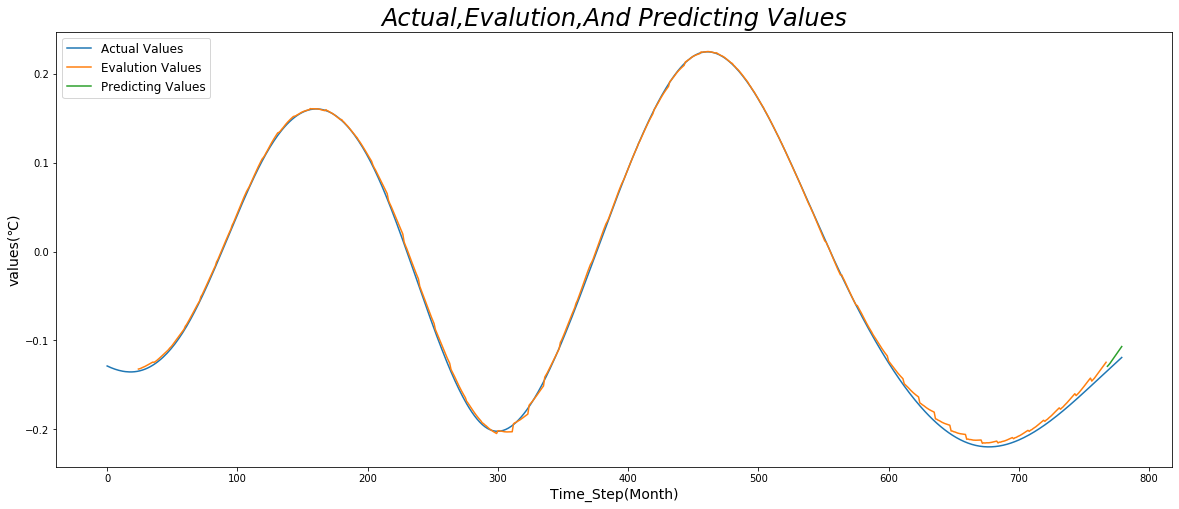

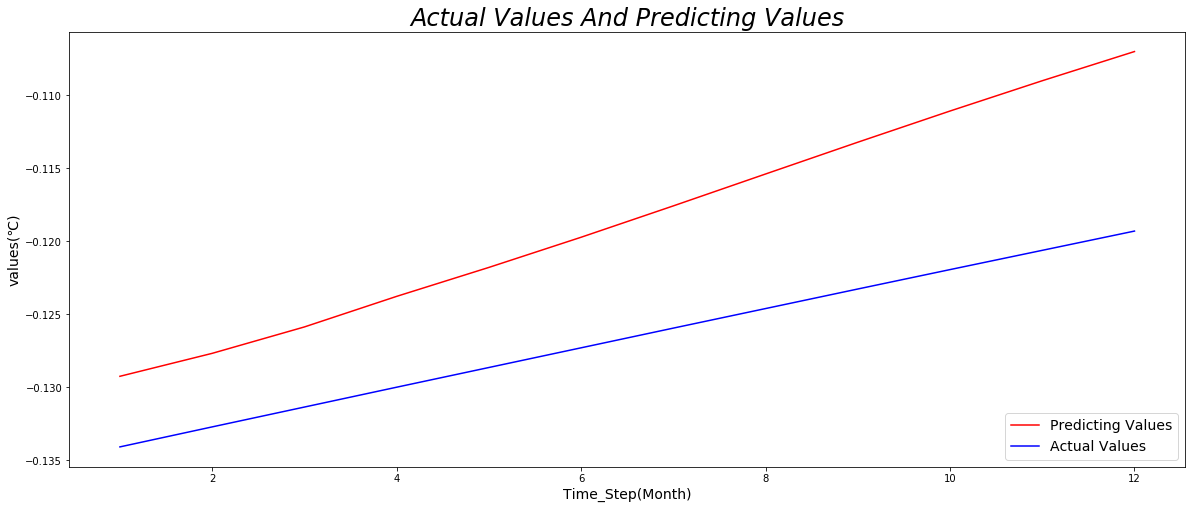

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
750    0.041182
751    0.041056
752    0.040928
753    0.040797
754    0.040665
755    0.040530
756    0.040392
757    0.040253
758    0.040111
759    0.039967
760    0.039821
761    0.039673
762    0.039523
763    0.039371
764    0.039216
765    0.039059
766    0.038901
767    0.038740
768    0.038577
769    0.038412
770    0.038245
771    0.038076
772    0.037905
773    0.037732
774    0.037557
775    0.037381
776    0.037202
777    0.037021
778    0.036838
779    0.036654
Name: f7, Length: 780, d

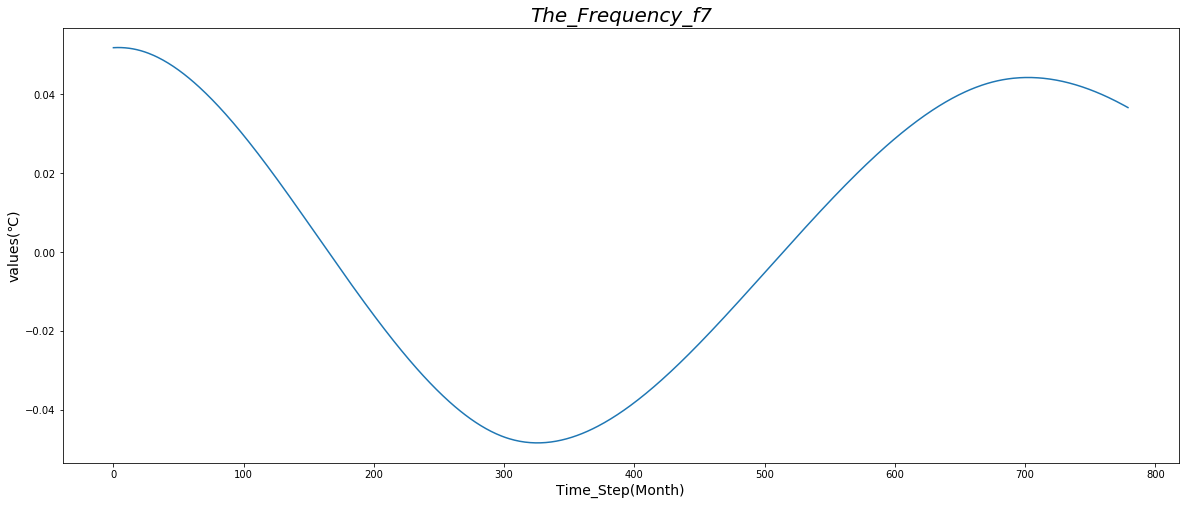

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 10s - loss: 8.3939e-04
Epoch 2/200
 - 3s - loss: 2.4048e-04
Epoch 3/200
 - 3s - loss: 1.2915e-04
Epoch 4/200
 - 3s - loss: 8.8694e-05
Epoch 5/200
 - 2s - loss: 5.7886e-05
Epoch 6/200
 - 2s - loss: 4.6972e-05
Epoch 7/200
 - 2s - loss: 4.1904e-05
Epoch 8/200
 - 2s - loss: 3.0652e-05
Epoch 9/200
 - 2s - loss: 2.9843e-05
Epoch 10/200
 - 2s - loss: 2.5839e-05
Epoch 11/200
 - 2s - loss: 2.4571e-05
Epoch 12/200
 - 2s - loss: 2.3453e-05
Epoch 13/200
 - 2s - loss: 2.0661e-05
Epoch 14/200
 - 2s - loss: 1.9041e-05
Epoch 15/200
 - 2s - loss: 2.1267e-05
Epoch 16/200
 - 2s - loss: 1.5750e-05
Epoch 17/200
 - 2s - loss: 2.1349e-05
Epoch 18/200
 - 2s - loss: 1.8133e-05
Epoch 19/200
 - 2s - loss: 8.6145e-06
Epoch 20/200
 - 2s - loss: 5.5407e-06
Epoch 21/200
 - 2s - loss: 6.9993e-06
Epoch 22/200
 - 2s - loss: 6.5471e-06
Epoch 23/200
 - 2s - loss: 6.2102e-06
Epoch 24/200
 - 2s - loss: 2.4429e-06
Epoch 25/200
 - 2s - loss: 1.0817e-06
Epoch 26/200
 - 2s - loss: 5.9330e-07
Epoch 27/200
 - 2s -

(62, 12)


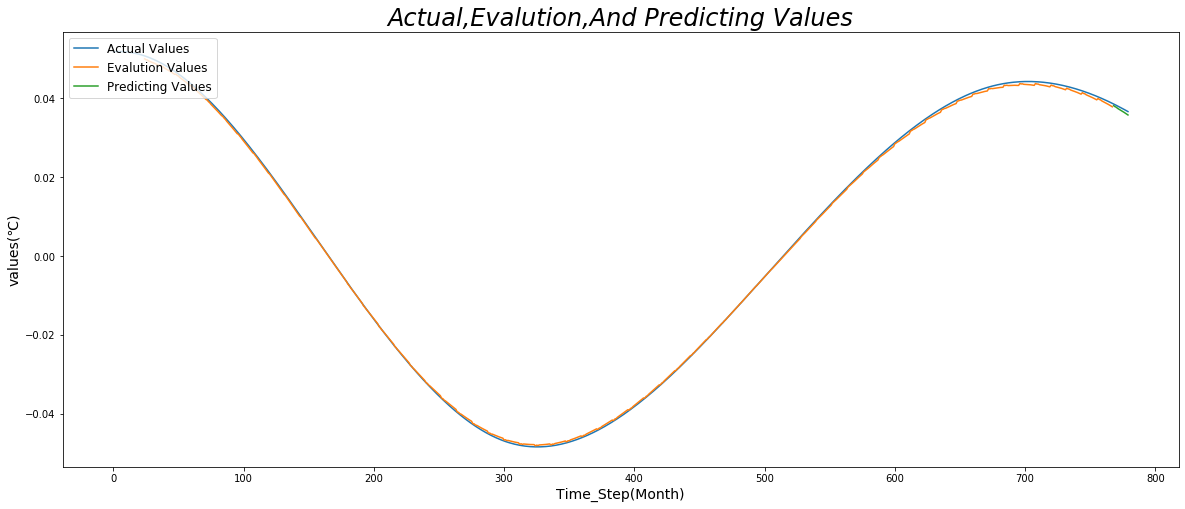

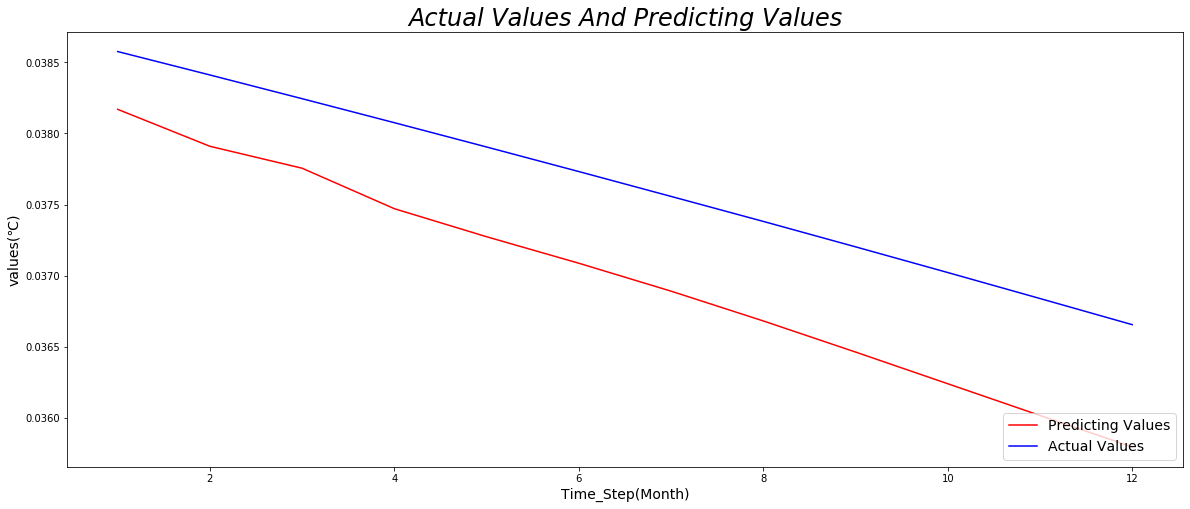

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
750    0.077861
751    0.077855
752    0.077849
753    0.077844
754    0.077838
755    0.077833
756    0.077828
757    0.077822
758    0.077817
759    0.077812
760    0.077806
761    0.077801
762    0.077796
763    0.077791
764    0.077786
765    0.077781
766    0.077776
767    0.077771
768    0.077766
769    0.077761
770    0.077756
771    0.077751
772    0.077746
773    0.077742
774    0.077737
775    0.077732
776    0.077728
777    0.077723
778    0.077718
779    0.077714
Name: f8, Length: 780, d

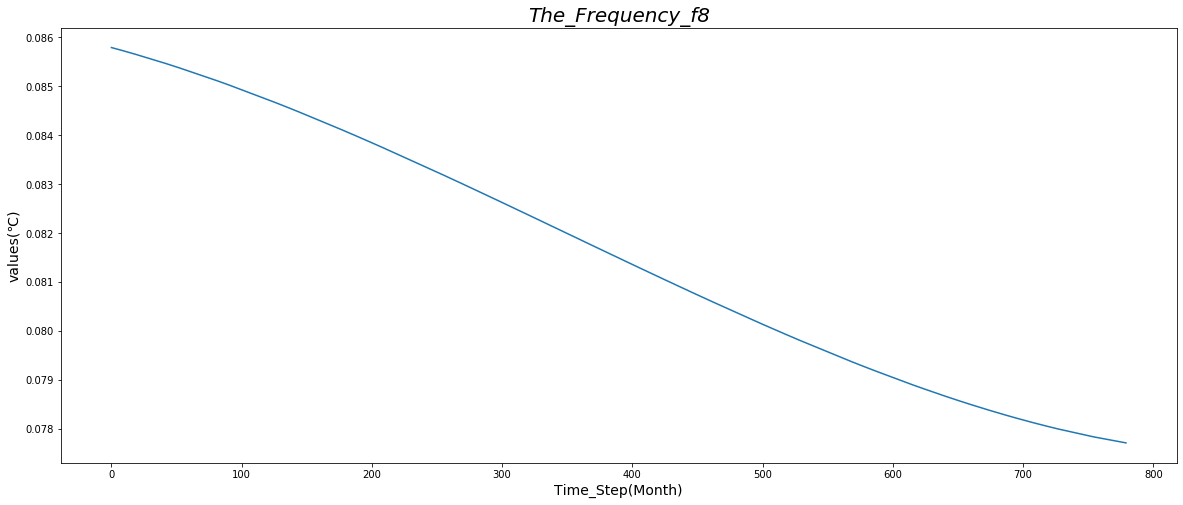

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 10s - loss: 5.4135e-04
Epoch 2/200
 - 3s - loss: 1.3514e-05
Epoch 3/200
 - 3s - loss: 6.8367e-06
Epoch 4/200
 - 2s - loss: 6.1427e-06
Epoch 5/200
 - 2s - loss: 6.3653e-06
Epoch 6/200
 - 2s - loss: 6.1405e-06
Epoch 7/200
 - 2s - loss: 6.2391e-06
Epoch 8/200
 - 2s - loss: 6.5680e-06
Epoch 9/200
 - 2s - loss: 6.4230e-06
Epoch 10/200
 - 2s - loss: 6.5123e-06
Epoch 11/200
 - 2s - loss: 6.1981e-06
Epoch 12/200
 - 2s - loss: 6.0256e-06
Epoch 13/200
 - 2s - loss: 6.3394e-06
Epoch 14/200
 - 2s - loss: 6.5887e-06
Epoch 15/200
 - 2s - loss: 6.2201e-06
Epoch 16/200
 - 2s - loss: 6.3955e-06
Epoch 17/200
 - 2s - loss: 6.0991e-06
Epoch 18/200
 - 2s - loss: 6.0731e-06
Epoch 19/200
 - 2s - loss: 6.8665e-06
Epoch 20/200
 - 2s - loss: 6.0228e-06
Epoch 21/200
 - 2s - loss: 6.0925e-06
Epoch 22/200
 - 2s - loss: 6.2265e-06
Epoch 23/200
 - 2s - loss: 5.9080e-06
Epoch 24/200
 - 2s - loss: 5.9692e-06
Epoch 25/200
 - 2s - loss: 5.8194e-06
Epoch 26/200
 - 2s - loss: 6.4619e-06
Epoch 27/200
 - 2s -

(62, 12)


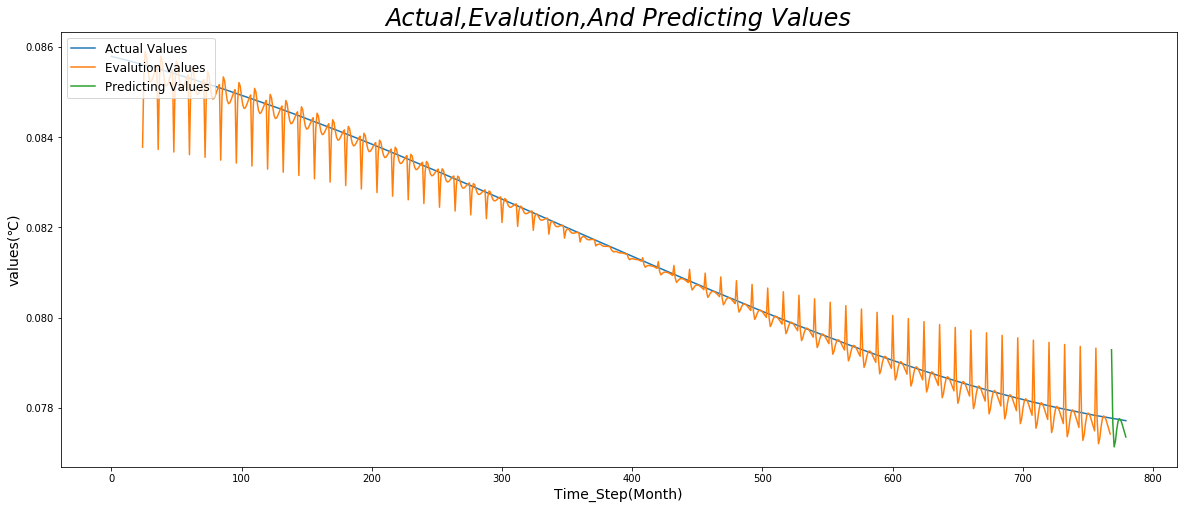

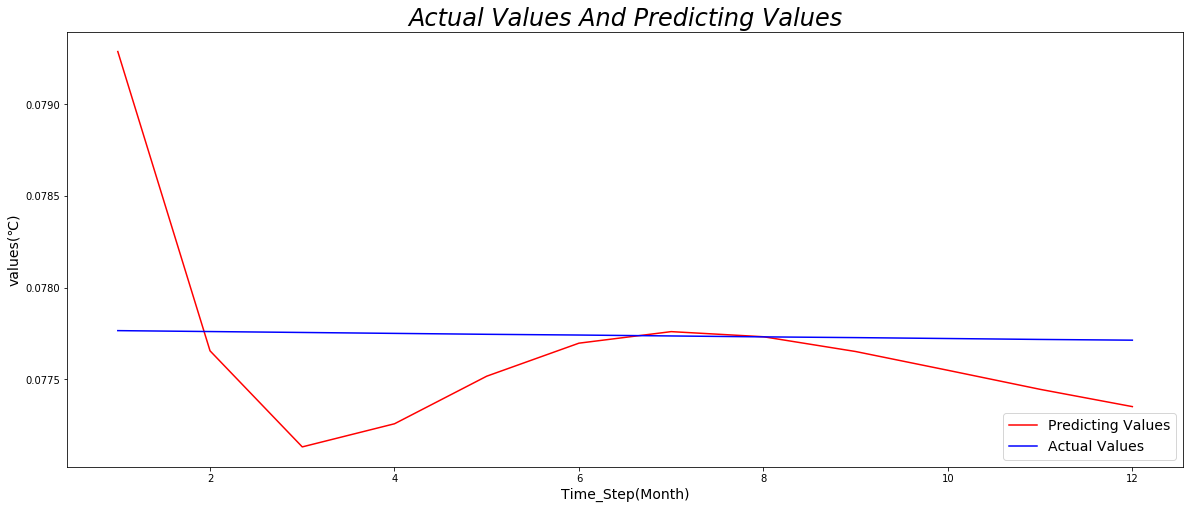

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-48]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.0792865 ]
 [0.07765593]
 [0.07713258]
 [0.07725855]
 [0.07751779]
 [0.07769771]
 [0.07776055]
 [0.07773271]
 [0.07765219]
 [0.07754992]
 [0.07744617]
 [0.07735205]]
[array([-0.089894 , -0.13353  , -0.040963 ,  0.1186   ,  0.18799  ,
        0.0013725, -0.14162  , -0.25001  , -0.037291 ,  0.16508  ,
        0.32117  ,  0.30398  ]), array([-0.066672, -0.071024, -0.019692,  0.057821,  0.11983 ,  0.13331 ,
        0.099123,  0.024204, -0.080189, -0.1829  , -0.24804 , -0.24948 ]), array([-0.047196, -0.05676 , -0.065907, -0.075071, -0.084464, -0.094279,
       -0.10407 , -0.11079 , -0.11117 , -0.10381 , -0.087494, -0.060201]), array([-0.33567 , -0.30635 , -0.26886 , -0.22402 , -0.1727  , -0.11583 ,
       -0.054297,  0.010972,  0.079005,  0.14871 ,  0.21899 ,  0.28871 ]), array([0.078862, 0.10251 , 0.12573 , 0.1485  , 0.17077 , 0.1925  ,
       0.21365 , 0.2342  , 0.25409 , 0.2733  , 0.29178 , 0.30949 ]), array([0.078314, 0.081709, 0.085052, 0.088342, 0.091576, 0.094752,
       0.097867,

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.089894  -0.13353   -0.040963   0.1186     0.18799    0.0013725
 -0.14162   -0.25001   -0.037291   0.16508    0.32117    0.30398  ]
[[-0.089894 ]
 [-0.13353  ]
 [-0.040963 ]
 [ 0.1186   ]
 [ 0.18799  ]
 [ 0.0013725]
 [-0.14162  ]
 [-0.25001  ]
 [-0.037291 ]
 [ 0.16508  ]
 [ 0.32117  ]
 [ 0.30398  ]]
[[-0.09]
 [-0.13]
 [-0.04]
 [ 0.12]
 [ 0.19]
 [ 0.  ]
 [-0.14]
 [-0.25]
 [-0.04]
 [ 0.17]
 [ 0.32]
 [ 0.3 ]]
-----------------------------------
observe value:[-0.066672 -0.071024 -0.019692  0.057821  0.11983   0.13331   0.099123
  0.024204 -0.080189 -0.1829   -0.24804  -0.24948 ]
[[-0.156566 ]
 [-0.204554 ]
 [-0.060655 ]
 [ 0.176421 ]
 [ 0.30782  ]
 [ 0.1346825]
 [-0.042497 ]
 [-0.225806 ]
 [-0.11748  ]
 [-0.01782  ]
 [ 0.07313  ]
 [ 0.0545   ]]
[[-0.16]
 [-0.2 ]
 [-0.06]
 [ 0.18]
 [ 0.31]
 [ 0.13]
 [-0.04]
 [-0.23]
 [-0.12]
 [-0.02]
 [ 0.07]
 [ 0.05]]
-----------------------------------
observe value:[-0.047196 -0.05676  -0.065907 -0.075071 -0.084464 -0.094279 -0.10407
 -

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.06827284 -0.0614726   0.01611732  0.06065662  0.02214704 -0.03116788
 -0.01973199  0.02875482  0.0471531   0.02208483 -0.01449392 -0.03554378]
[-0.06827284 -0.0614726   0.01611732  0.06065662  0.02214704 -0.03116788
 -0.01973199  0.02875482  0.0471531   0.02208483 -0.01449392 -0.03554378]
the 1 frequence:
predicted_value:[-0.09098824 -0.07709251 -0.04388335  0.00274444  0.0442852   0.06934066
  0.0741549   0.06147661  0.03817144  0.01182342 -0.01193247 -0.03023861]
[-0.15926108 -0.13856511 -0.02776603  0.06340106  0.06643224  0.03817278
  0.05442291  0.09023143  0.08532454  0.03390825 -0.02642639 -0.06578239]
the 2 frequence:
predicted_value:[-0.03072355 -0.03322768 -0.03373318 -0.03111805 -0.02643976 -0.01986751
 -0.01102388 -0.0007064   0.0081016   0.01153384  0.00711897 -0.00516108]
[-0.18998463 -0.17179279 -0.06149921  0.03228301  0.03999248  0.01830527
  0.04339903  0.08952503  0.09342615  0.04544209 -0.019

[[-0.4]
 [-0.4]
 [-0.2]
 [ 0.1]
 [ 0.3]
 [ 0.2]
 [ 0.1]
 [-0. ]
 [ 0.2]
 [ 0.4]
 [ 0.6]
 [ 0.7]]
[-0.35270896 -0.26366526 -0.08726341  0.07767712  0.16348569  0.22249183
  0.32873771  0.45504803  0.53608644  0.55891923  0.55442509  0.54811581]


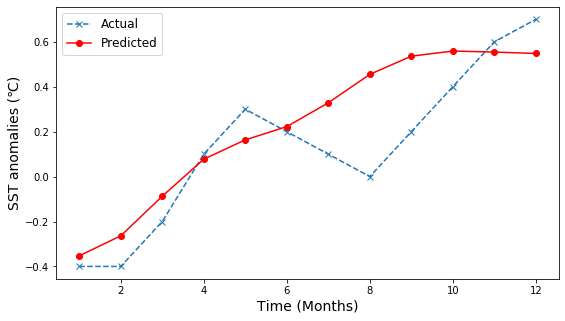

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
